# Time Series Forecasting mit rekurrenten neuronalen Netzen
Dieses Notebook entsteht im Rahmen des Moduls `Deep Learning` an der Fachhochschule Südwestfalen. Es beschäftigt sich mit dem Thema `Time Series Forecasting` und untersucht die Anwendung von rekurrenten neuronalen Netzen (RNN) auf Zeitreihendaten....

## 1. Einleitung

## 2. Was ist Time Series Forecasting (Zeitreihenvorhersage)?

Christian

Definition gemäß der Webseite Studysmarter:<br>
**Zeitreihenprognose** ist eine statistische Methode zur Vorhersage zukünftiger Ereignisse oder Werte, indem historische Zeitreihendaten analysiert und Muster erkannt werden. [C1]

Beispiele:<br>
- Wetterdaten für zukünftiges Wetter (https://www.studysmarter.de/studium/mathematik-studium/statistik-studium/zeitreihenprognose/)
- Aktienkurse für zukünftige Aktienverläufe
- Passagierzahlen für zukünftige Passagiervorhersagen (https://data-science-crashkurs.de/chapters/kapitel_09.html)

Die Seite https://www.emft.fraunhofer.de/de/kompetenzen/systemloesungen-ki/ki-algorithmen-zeitreihenanalyse.html nennt zudem noch folgende mögliche Beispiele:
- Industrie 4.0 mit IIoT (Industrial Internet of Things)
- Logistik
- Finanzen
- Stromnetze
- Internetverkehr
- Umweltmonitoring
- Gesundheitsdaten

Außerdem werden auf der Seite typische Methoden der künstlichen Intelligenz inklusive grafischer Beispiele genannt, wie z.B.: Regression, Klassifikation, Anomalieerkennung, Vorhersage

Grafisches Beispiel einer Klassifikation:<br>
<img style = 'border: 5px solid #555' src="Pictures/classification-dt-mls-emft.jpg" width="30%" alt="Grafisches Beispiel einer Klassifikation"> 
<br>
Grafisches Beispiel einer Anomalieerkennung:<br>
<img style = 'border: 5px solid #555' src="Pictures/anomaly-dt-mls-emft.jpg" width="30%" alt="Grafisches Beispiel einer Anomalieerkennung">
<br>
Grafisches Beispiel einer Anomalieerkennung:<br>
<img style = 'border: 5px solid #555' src="Pictures/forecasting-dt-mls-emft.jpg" width="30%" alt="Grafisches Beispiel einer Vorhersage">

### Einlesen einer CSV-Tabelle
Das nachfolgende angepasste Beispiel verwendet als Grundlage Fahrgastzähldaten für Bus und Bahn aus Chicago [C2][C3, pp. 583-594]

Dabei wird die zur Verfügung stehende CSV-Datei eingelesen. Die Tabelle wird angepasst durch Setzen von kürzeren Spaltennamen, Datumssortierung und Entfernen von Duplikaten. Die "total" Spalte wird zusätzlich entfernt, da sie für das Beispiel nicht benötigt wird.


In [67]:
import pandas as pd
from pathlib import Path

path = Path("Data/CTA_-_Ridership_-_Daily_Boarding_Totals_20241229.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Zu den Daten (erste fünf Tage der Zeitreihe) werden jeweils die Fahrgastzahlen für Bus und Bahn angegeben. Als Tagtyp sind A, U und W möglich, wobei A für Samstage, U für Sonn- und Feiertage und W für Wochentage steht. 

### Ausgabe als Graph
Die Zeitreihe hat die Eigenschaft **multivariat**, da pro Zeiteinheit zwei Werte angegeben sind.
Gibt man die Daten als Grafik über drei Monate aus, sieht es wie folgt aus.

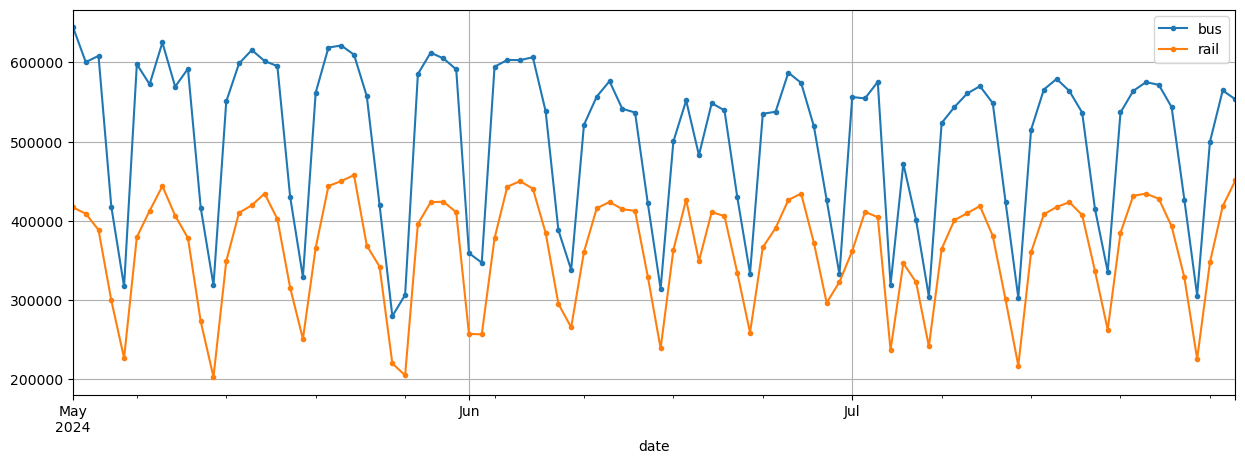

In [32]:
import matplotlib.pyplot as plt

df["2024-05":"2024-07"].plot(grid=True, marker=".", figsize=(15,5))
plt.show()

### Naives Forcasting und Differencing
Da die Daten wöchentlich saisonal sind, wäre ein erster Ansatz ein **naives Forecasting**, indem man Werte aus der Vergangenheit über einen gleichen Zeitraum auf die aktuellen Werte legt und diese dann vergleicht. Die Daten aus der Vergangenheit werden um vier Wochen nach rechts verschoben, um die Graphen bildlich miteinander zu vergleichen. Außerdem werden die Differenzen der jeweiligen Tage in einer separaten Grafik mit ausgegeben (**Differencing**).

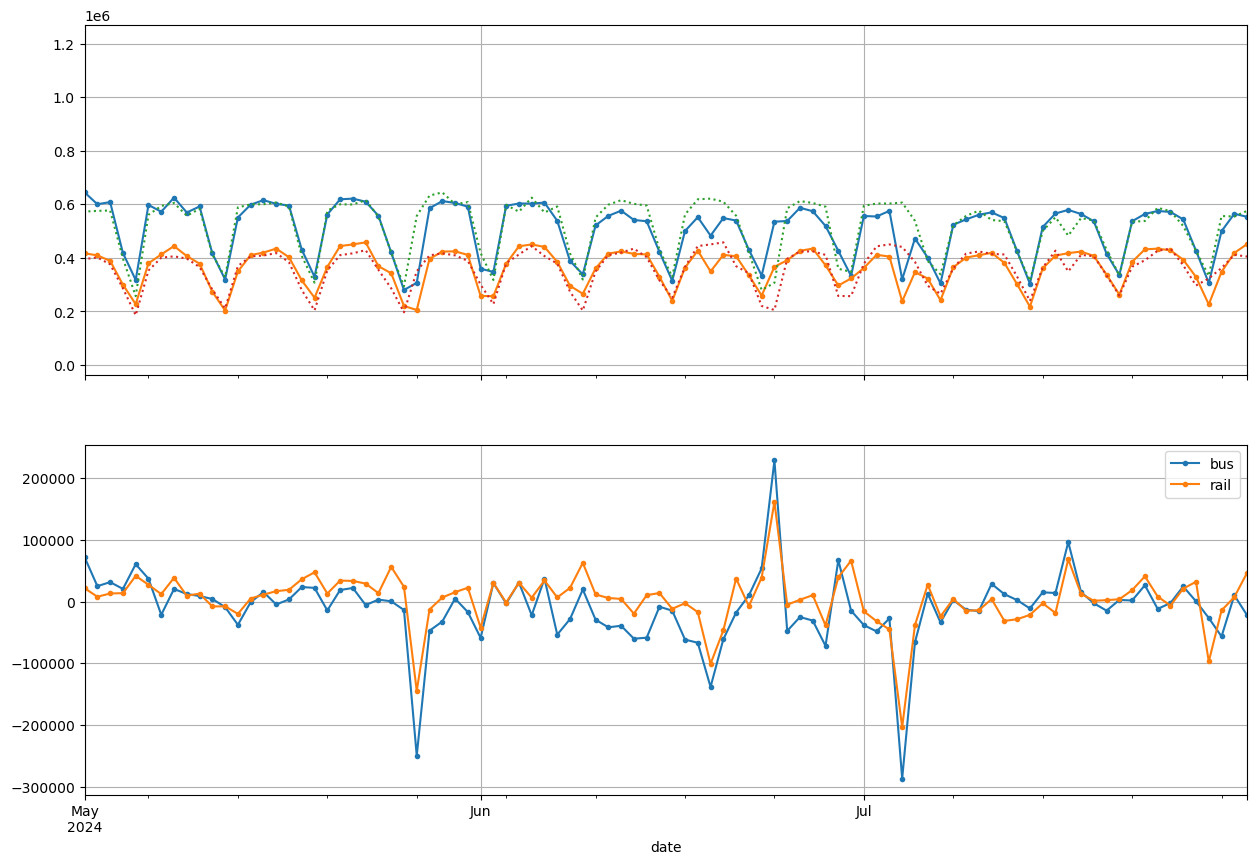

In [33]:
diff_28 = df[["bus", "rail"]].diff(28)["2024-05":"2024-07"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))
df.plot(ax = axs[0], legend=False, marker=".") #ursprüngliche Zeitserie
df.shift(28).plot(ax=axs[0], grid=True, legend=False, linestyle=":") #verschobene Zeitserie
diff_28.plot(ax=axs[1], grid=True, marker=".")

plt.show()


Man erkennt zwei besonders hohe negative Differenzen: Einmal für Ende Mai und einmal für Anfang Juli.<br> 
Bei einem Vergleich der Tagtypen in den jeweiligen Wochen fällt auf, dass am 27. Mai (Memorial Day) und am 04. Juli (Amerikanischer Unabhängigkeitstag) jweils ein Feiertag war.

In [34]:
print(list(df.loc["2024-05-24":"2024-05-30"]["day_type"]))
print(list(df.loc["2024-07-01":"2024-07-07"]["day_type"]))

['W', 'A', 'U', 'U', 'W', 'W', 'W']
['W', 'W', 'W', 'U', 'W', 'A', 'U']


### MAE und MAPE
Verwenden des mittleren absoluten Fehlers (Mean Absolute Error - **MAE**) und <br>
mittlerer absoluter prozentualer Fehler (Mean Absolute Percentage Error - **MAPE**)
Für naives Forcasting ist insbesondere der **MAPE** sehr gut, kann aber noch verbessert werden.

In [36]:
print(diff_28.abs().mean())
targets = df[["bus", "rail"]]["2024-05":"2024-07"]
print("")
print((diff_28 / targets).abs().mean())

bus     35114.543478
rail    27876.956522
dtype: float64

bus     0.078065
rail    0.088024
dtype: float64


### Prüfung jährliche Saisonalität
Weiteres Beispiel zur Prüfung einer jährlichen Saisonalität inklusive des Einbruchs von Fahrgastzahlen während der Corona-Pandemie.<br>
Zusätzlich **Differencing** um 12 Monate zum Entfernen der jährlichen Saisonalität und begradingen von Trends.

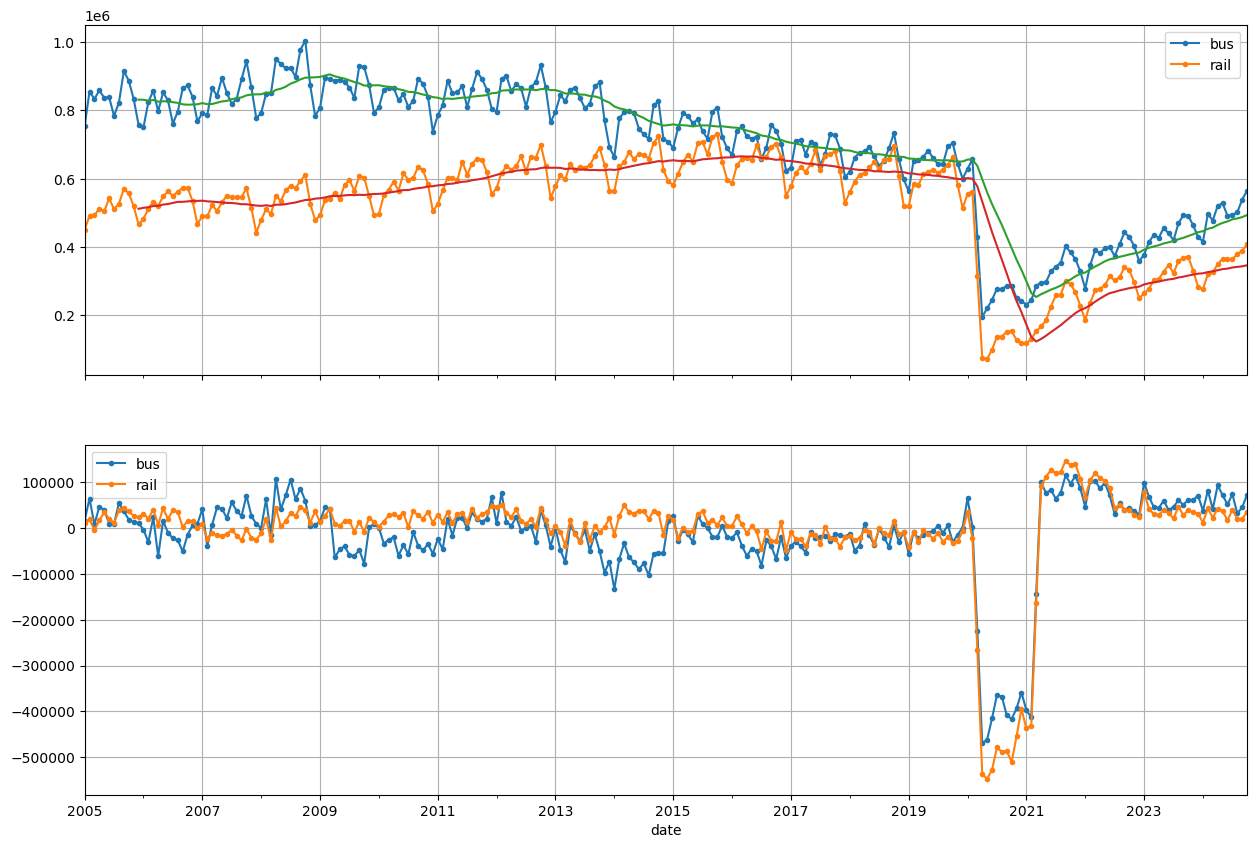

In [66]:
period = slice("2005", "2024")
df_temp = df.drop("day_type", axis=1)
df_monthly = df_temp.resample('M').mean() #Mittelwert für jeden Monat
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, axs = plt.subplots(2,1,sharex=True, figsize=(15,10))
df_monthly[period].plot(ax=axs[0], marker=".")
rolling_average_12_months.plot(ax=axs[0], grid=True, legend=False)
#plt.show()

df_monthly.diff(12)[period].plot(ax=axs[1], grid=True, marker=".")
plt.show()

Quellen:
* C1: StudySmarter GmbH. (2024) Zeitreihenprognose: Methoden & Anwendung | StudySmarter. https://www.studysmarter.de/studium/mathematik-studium/statistik-studium/zeitreihenprognose/. 29.12.2024
* C2: https://homl.info/ridership
* C3: Géron Aurélien, Praxiseinstieg Machine Learning mit Scikit-Learn, Keras und TensorFlow, 3. Auflage, 2023, 978-3-96009-212-4

## 3. Was sind recurrent neural networks (Rekurrente neuronale Netzwerke)?

Ein rekurrentes oder auch rückgekoppeltes neuronales Netzwerk (RNN) ist ein künstliches neuronales Netzwerk, dass bei jeder Verarbeitung einer Einheit auch ein Ergebnis aus einer früheren Iteration erhält. Damit eignet es sich besonders für die Verarbeitung von sequentiellen Daten, wie z.B. Zeitreihendaten, Text oder Sprache.
Ein RNN funktioniert, indem es eine spezielle Ausgabe des vorherigen Schrittes, den hidden state oder auch state vector, als zusätzlichen Input für den nächsten Schritt verwendet. Das bedeutet, dass immer zwei Ausgaben generiert werden. Dadurch kann es sich an vorherige Iterationen erinnern und somit auch auf längere Abhängigkeiten in den Daten reagieren. Das eigentliche Ergebnis wird dabei nur im letzten Schritt betrachtet. [T1, S. 116ff]

<img style = 'border: 5px solid #555' src="Pictures/rnn-ablauf.png" width="30%" alt="Ablauf eines RNN">

[T1, S. 117]

Das Bild zeigt den sequentiellen Ablauf eines RNN. Dabei bezeichnet "t" den aktuellen Schritt. Diese Schritte könnten bei der Verarbeitung von Text z.B. einzelne Wörter oder Buchstaben sein. Der hidden state wird dabei in jedem Schritt aktualisiert und an den nächsten Schritt weitergegeben.

Die Verarbeitung einer Interation erfolgt dabei in drei Schritten die in folgendem Bild dargestellt sind:

<img style = 'border: 5px solid #555' src="Pictures/rnn-schritte.png" width="30%" alt="Ablauf einer RNN Iteration">

[T1, S. 119]

Der erste Schritt verbindet die beiden Eingangsvektoren zu einem einzigen Vektor. Anschließend wird der hidden State aktualisiert und im letzten Schritt wird der Ausgabewert berechnet.

Das vorangegangene Beispiel lässt sich mit wenigen Zeilen Code in PyTorch implementieren. Bei dem nachfolgenden Code handelt es lediglich um einen Auszug und nicht um ein vollständiges, lauffähiges Beispiel.

```python
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # input to hidden als lineare Schicht
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # input to output als lineare Schicht
        self.softmax = nn.LogSoftmax(dim=1) # softmax function for output
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # Eingabedaten und hidden state kombinieren
        hidden = self.i2h(combined) # hidden state berechnen
        output = self.i2o(combined) # output berechnen
        output = self.softmax(output) # softmax anwenden
        return output, hidden 
    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size)) # initialize hidden state with zeros

# Modell ausführen
rnn = RNN(input_size, hidden_size, output_size)
hidden = rnn.initHidden() # hidden state initialisieren

for i in range(len(toy_story_review)):
    output, hidden = rnn(toy_story_review[i], hidden) # Jedes Wort verarbeiten
```
[T1, S. 118]

Da ein RNN nun auch eine Zeitkomponente mit bringt, ist der normale Backpropagation Algorithmus nicht anwendbar, da dieser die Schritte des RNN nicht berücksichtigen kann.
Die Formel für den Backpropagation Algorithmus lautet:
$$ \Delta w_{ij} = -\eta \frac{\partial E}{\partial w_{ij}} $$
Dabei ist $ \Delta w_{ij} $ das gewicht zwischen den Neuronen i und j, $ \eta $ die Lernrate und $ \partial E $ der Fehler der Fehlerfunktion (Loss).


Um dieses Problem zu lösen wurde der "Backpropagation through time" Algorithmus entwickelt. Dieser besteht aus vier Schritten:

Zuerst wird der Fehler $ \delta_t $ für jeden Zeitschritt berechnet. Dieser wird mit der Ableitung der Aktivierungsfunktion $ g'(y_t) $ multipliziert. Als aktivierungsfunktion verwendet man üblicherweise die Tanh-Funktion.
$$ \delta_t = \frac{\partial E}{\partial y_t} \cdot g'(y_t) $$

Anschließend wird der Gradient für jeden Zeitschritt berechnet, indem die zuvor berechneten Fehler $ \delta_t $ mit dem hidden statedes Zeitschritts $ \cdot h_t^T $ multipliziert und anschließend aufsummiert werden.
$$ \Delta W_y = \sum_{t} \delta_t \cdot h_t^T $$

Danach wird der Gradient des hidden state $ \Delta W_h $ berechnet. Dafür wird der Fehler $ \delta_t $ mit der Ableitung des hidden state multipliziert und wieder über alle Zeitschritte aufsummiert.
$$ \Delta W_h = \sum_{t} \delta_t \cdot \frac{\partial h_t}{\partial W_h} $$

Zuletzt wird der Gradient des Eingangsvektors berechnet. Dies geschieht analog zum vorherigen Schritt, nur dass hier der Fehler $ \delta_t $ mit der Ableitung des Eingangsvektors $ \delta W_x $, anstatt dem hidden state $ \delta W_h $, multipliziert wird.
$$ \Delta W_x = \sum_{t} \delta_t \cdot \frac{\partial h_t}{\partial W_x} $$

Diese einfache Form von RNNs hat jedoch zwei Probleme, die als Vanishing und Exploding Gradient Problem bekannt sind. Diese treten auf, wenn eine große Sequenz an Daten verarbeitet werden soll. Bei diesen Problemen werden die Gradienten entweder zu klein oder zu groß, um sinnvolle Änderungen an den Gewichten vornehmen zu können. Dadurch kann das RNN keine langfristigen Abhängigkeiten in den Daten erkennen. Um dieses Problem zu lösen, gibt es verschiedene Ansätze wie zum Beispiel das Gradient Clipping, was die Werte der Gradienten mit einem Maximal- und einem Minimalwert begrenzt, oder der Einsatz von Normalisierungstechniken wie dem Layer Normalization oder dem Batch Normalization. [T2, S. 275ff]
In realen Anwendungsszenarien werden jedoch speziell aufgrund dieser Probleme entwickelte Netzwerke wie das Long Short-Term Memory (LSTM) oder das Gated Recurrent Unit (GRU) verwendet. Diese Netzwerke sind in der Lage, langfristige Abhängigkeiten in den Daten zu erkennen und zu verarbeiten.

Das Long Short-Term Memory (LSTM) Netzwerk wurde 1997 von Sepp Hochreiter und Jürgen Schmidhuber entwickelt, um die Probleme des einfachen RNN zu lösen.
Dabei ist folgende Architektur entstanden:

 <img style = 'border: 5px solid #555' src="./Pictures/lstm-zelle.png" width="50%" alt="Architektur eines LSTM">
 
 [T2, S. 407]
 
Oben in der Abbildung ist eine gerade Linie, vom Eingang c(t-1), zu sehen, die mit nur wenigen Schritten Informationen weitergibt. Dies ist das "Langzeitgedächtnis" (L) des LSTM. Dieses passiert zuerst das sogenannte "Forget-Gate", wo mittels einer elementweisen Multiplikation entschieden wird welche Information vergessen werden soll. Die Entscheidung welche Information vergessen werden soll, wird durch die Sigmoid (logistische) Funktion f(t) entschieden die nach einer linearen Schicht auf die Daten des "Kurzzeitgedächtnisses" (S) h(t-1) zusammen mit dne aktuellen Eingabedaten x(t) angewendet wird. Anschließend wird über die Tanh Funktion g(t), wieder nach einer linearen Schicht mit den Daten aus h(t-1) und x(t), entschieden welche neuen Informationen in das Langzeitgedächtnis übernommen werden sollen. Zuvor werden diese Daten noc h durch eine weitere Sigmoid Funktion i(t) gefiltert. Das Langzeitgedächtnis wird ab dieser Stelle nicht mehr verändert und kann ausgegeben werden. Das Kurzzeitgedächtnis durch eine Tanh Funktion und einer Sigmoid Funktion o(t) gefiltert und ausgegeben. Die Sigmoid Funktion o(t) entscheidet dabei welche Informationen aus dem Langzeitgedächtnis ausgegeben werden sollen. Dieses Ergebnis ergibt dann das neue Kurzzeitgedächtnis h(t), dass an den nächsten Schritt weitergegeben werden kann, und das aktuelle Ergebnis y(t). [T2, S. 406ff]

Eine neuere Variante des LSTM ist das Gated Recurrent Unit (GRU). Dieses wurde 2014 von Kyunghyun Cho et al. entwickelt und ist eine vereinfachte Version des LSTM. Es besteht aus zwei Gates, dem Reset-Gate (Forget-Gate) und dem Update-Gate (Eingabe-Gate). Das Reset-Gate entscheidet, welche Informationen vergessen werden sollen, und das Update-Gate entscheidet, welche Informationen im hidden state behalten werden sollen. [T2, S. 410]

Die Architektur des GRU sieht folgendermaßen aus:

<img style = 'border: 5px solid #555' src="Pictures/gru-zelle.png" width="50%" alt="Architektur eines GRU">

[T2, S. 410]

Im Vergleich zum LSTM ist weniger komplex. Der auffälligste Unterschied ist das Fehlen des Langzeitgedächtnisses. Beim GRU werden Lang- und Kurzzeitgedächtnis in einem hidden state zusammengefasst. Das Reset- und das Update-Gate werden dabei durch einen einzigen Controller, einer linearen Schicht und einer Sigmoid Funktion z(t), gesteuert. Dabei wird das Ergebnis für das Forget-Gate negiert. Wird eine Information hinzugefügt, wird als Gegenteil zuvor eine andere vergessen. Die Informationen die hinzugefügt werden sollen stammen aus einer Tanh Funktion und einer Sigmoid Funktion r(t). Beim GRU entspricht dann der hidden state auch dem Ausgabewert. [T2, S. 410]

Quellen:
* T1: Mitchell, L. et al. (2019) Deep learning with Pytorch 1. x: implement deep learning techniques and neural network architecture variants using Python /. Second edition. Birmingham; Packt Publishing.
* T2: Géron, A. & Rother, K. (2018) Praxiseinstieg Machine Learning mit Scikit-Learn und TensorFlow: Konzepte, Tools und Techniken für intelligente Systeme. 1. Auflage. Heidelberg: O’Reilly.
* T3: Sepp Hochreiter, Jürgen Schmidhuber; Long Short-Term Memory. Neural Comput 1997; 9 (8): 1735–1780. doi: https://doi.org/10.1162/neco.1997.9.8.1735


## 4. Datenbeschaffung

Für die folgenden Implementierungen verschiedener RNNs wird ein Datensatz der Plattform "Kaggle" [T5] verwendet. Kaggle ist eine Plattform der Google LLC und bietet eine Vielzahl von Datensätzen und Modellen für Machine Learning und Data Science Projekte aber auch Wettbewerbe und Kurse an. An dieser Stelle sei noch auf die Plattform "Hugging Face" [T6] erwähnt, die ebenfalls eine Vielzahl von Modellen und Datensätzen für Machine Learning und Data Science Projekte anbietet.

Der verwendeten Daten "Gold and Silver prices (2013-2024)" beinhaltet den täglichen Goldpreis von 2013 bis zum November 2024. Der Datensatz wurde von Alexander Kapturov unter der CC0: Public Domain Lizenz veröffentlicht, wodurch er für alle Zwecke frei verwendet werden kann.

Der Datensatz wird als CSV-Datei bereitgestellt und beinhaltet folgende Spalten:
* Date: Das Datum des Datensatzes im Format mm/DD/yyyy
* Close/Last: Der Schlusskurs des Goldpreises in US-Dollar pro Unze
* Volume: Das gehandelte Volumen des Goldes in Unzen
* Open: Der Eröffnungskurs des Goldpreises in US-Dollar pro Unze
* High: Der höchste Kurs des Goldpreises an diesem Tag in US-Dollar pro Unze
* Low: Der niedrigste Kurs des Goldpreises an diesem Tag in US-Dollar pro Unze

Für die weitere Analyse wird der Datensatz in ein Pandas DataFrame geladen. Dabei wird die Spalte date als index genutzt.

In [9]:
import pandas as pd

df = pd.read_csv('Data/gold_prices_raw.csv', index_col='Date')
df.describe()

,Close/Last,Volume,Open,High,Low
count,2539.000000,2511.000000,2539.000000,2539.000000,2539.000000
mean,1467.437456,183765.289128,1467.455967,1477.035880,1457.630721
std,282.891621,98028.942525,283.126968,285.232942,280.366732
min,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,1243.900000,123166.500000,1243.850000,1251.250000,1235.800000
50%,1321.400000,172127.000000,1321.700000,1329.300000,1314.000000
75%,1774.050000,233415.000000,1773.950000,1785.000000,1763.550000
max,2069.400000,787217.000000,2076.400000,2085.400000,2049.000000


Die Funktion `describe` gibt einen Überblick über die Daten, indem sie verschiedene Werte über die Daten anzeigt.
In der ersten Zeile sehen wir die Anzahl der Einträge die nicht NULL sind. Dort sehen wir auch ein erstes Problem. Anscheinend fehlt für 28 Tage das gehandelte Volumen.
Die Zeile mean zeigt den Mittelwert der Daten.
Die Zeile std zeigt die Standardabweichung.
Die Zeilen min und max zeigen jeweils den niedrigsten und höchsten Wert der Spalte an.
Die Zeilen mit den Prozentwerten geben an, dass x prozent der Daten unter diesem Wert liegen oder ihm genau entsprechen.
Man sieht außerdem das die Werte für das Volumen meistens deutlich größer sind als die Preise. Dieser Unterschied der Wertebereiche verschelchtert das Training und sollte daher vor der Nutzung in einem Modell skaliert werden.

In [10]:
len(df)

2539

Der Datensatz hat insgesamt 2539 Einträge

In [11]:
null_values = df.isnull().any(axis=1) # Suche auf Achse 1 (Spalten) nach NULL-Werten
null_rows = df[null_values] # Hole alle Zeilen der Datensätze mit NULL-Werten

print(null_rows)

            Close/Last  Volume    Open    High     Low
Date                                                  
10/18/2022      1655.5     NaN  1655.5  1655.5  1655.5
10/14/2022      1672.9     NaN  1672.9  1672.9  1672.9
10/13/2022      1672.9     NaN  1672.9  1672.9  1672.9
03/27/2020      1623.9     NaN  1623.9  1623.9  1623.9
11/21/2018      1225.8     NaN  1225.8  1225.8  1225.8
09/19/2018      1202.2     NaN  1202.2  1202.2  1202.2
12/25/2015      1075.9     NaN  1075.9  1075.9  1075.9
11/26/2015      1069.7     NaN  1069.7  1069.7  1069.7
09/07/2015      1121.4     NaN  1121.4  1121.4  1121.4
07/03/2015      1163.5     NaN  1163.5  1163.5  1163.5
05/25/2015      1204.0     NaN  1204.0  1204.0  1204.0
04/03/2015      1200.9     NaN  1200.9  1200.9  1200.9
02/16/2015      1227.1     NaN  1227.1  1227.1  1227.1
01/19/2015      1276.9     NaN  1276.9  1276.9  1276.9
01/01/2015      1184.1     NaN  1184.1  1184.1  1184.1
12/25/2014      1173.5     NaN  1173.5  1173.5  1173.5
11/27/2014

Hier haben wir nun alle Zeilen ohne einen Wert in mindestens einer Spalte. Die fehlenden Werte sind zufällig und nicht zusammenhängend. Betrachten wir für den obersten Datensatz die umliegenden Werte.

In [12]:
df[206:211]

,Close/Last,Volume,Open,High,Low
Date,,,,,
10/20/2022,1636.8,159797.0,1634.6,1650.3,1626.3
10/19/2022,1634.2,172551.0,1657.2,1659.8,1632.2
10/18/2022,1655.5,NaN,1655.5,1655.5,1655.5
10/17/2022,1664.0,144374.0,1649.9,1674.3,1649.1
10/14/2022,1672.9,NaN,1672.9,1672.9,1672.9


Man kann sehen, dass an den Tagen vor und nach den Tagen ohne Werte Handel stattgefunden hat, da diese ein Volumen angegeben haben und auch verschiedene Werte für die einzelnen Spalten haben. Die Datensätze mit fehlendem Umsatz haben in allen Spalten den gleichen Wert. Man kann also davon ausgehen, dass an diesen tagen kein Handel stattgefunden hat. Daher können die fehlenden Werte durch den Wert 0 ersetzt werden.

In [13]:
df['Volume'] = df['Volume'].fillna(0)
df.describe()

,Close/Last,Volume,Open,High,Low
count,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000
mean,1467.437456,181738.732178,1467.455967,1477.035880,1457.630721
std,282.891621,99358.470659,283.126968,285.232942,280.366732
min,1049.600000,0.000000,1051.500000,1062.700000,1045.400000
25%,1243.900000,121111.500000,1243.850000,1251.250000,1235.800000
50%,1321.400000,171291.000000,1321.700000,1329.300000,1314.000000
75%,1774.050000,232716.000000,1773.950000,1785.000000,1763.550000
max,2069.400000,787217.000000,2076.400000,2085.400000,2049.000000


Wie man nun sehen hat die Spalte Volume auch 2539 Einträge und der Minimalwert ist auch von 1.0 auf 0.0 gesunken. Damit sind die Daten nun für die weitere Verwendung geeignet und können abgespeichert werden.

In [14]:
df.to_csv('Data/gold_prices.csv')

Quellen:
* T4: https://www.kaggle.com/datasets/kapturovalexander/gold-and-silver-prices-2013-2023, [Online, Stand: 03.01.2025]
* T5: https://www.kaggle.com/, [Online, Stand: 03.01.2025]
* T6: https://huggingface.co/, [Online, Stand: 03.01.2025]

## 5. Implementierung eines RNN

In diesem Abschnitt werden eigene RNNs erstellt, welche mit aktuellen Architekturen verglichen werden.
Zuerst müssen die Daten in einem `DataLoader` bereitgestellt werden, um von dem Modell verwendet werden zu können. PyTorch bietet keine native Methode um CSV-Daten als `DataLoader` einzulesen. Daher muss eine neue Unterklasse der `Dataset`-Klasse erstellt werden, die mit CSV-Daten umgehen kann. Dieses `Dataset` kann dann in einem `DataLoader` verwendet werden.

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Data/gold_prices.csv') # Einlesen der CSV-Datei als DataFrame

Dee eingelesene `DataFrame` wird zur einfacheren Handhabung etwas angepasst. Die Spalte 'Close/LastÄ wird ubenannt zu 'Close' und die 'Date' Spalte wird als Datum mit dem angegebenen Format definiert. Anschließend werden die Einträge nach Datum sortiert und doppelte Einträge basierend auf dem Datum entfernt. ZUletzt wird ein neuer `DataFrame` nur mit den Spalten 'Date' und 'Close' erstellt.

In [4]:
df = df.rename(columns={"Close/Last": "Close"}) # Spalte Close/Last zu Close umbenennen
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y') # Spalte Date als Date im Format Monat/Tag/Jahr definieren

df.sort_values(by='Date', ascending=True, inplace=True) # Nach Datum sortieren von früh bis spät

df.drop_duplicates(subset=['Date'], keep='first', inplace=True) # Doppelte Einträge entfernen. Es soll jeweils der erste erhalten bleiben
df.reset_index(drop=True, inplace=True)

df = pd.DataFrame(df, columns=['Date', 'Close']) # Neuer DataFrame nur mit Date und Close

Als nächstes werden die Daten mit `scikit-learn` normalisiert, damit die Modelle effizienter trainiert werden können. Dafür werden zwei Funktionen erstellt. Die Funktion `transform_data` nutzt den `MinMaxScaler` um die Features in den Bereich zwischen 0 und 1 zu skalieren. Die Funktion `inverse_transform_data` macht die Skalierung wieder rückgängig.

In [5]:
# Normalisierung
scaler = MinMaxScaler(feature_range=(0, 1))

def transform_data(scaler, df):
    
    normalized_data = scaler.fit_transform(df)
    return normalized_data

def inverse_transform_data(scaler, data):
    unnormalized_data = scaler.inverse_transform(data)
    return unnormalized_data

# Wir nutzen für die Vorhersage nur die Spalte Close. Diese wird in ein Numpy Array gewandelt und in ein 2-D Array konvertiert.
data = transform_data(scaler, df['Close'].to_numpy().reshape(-1, 1))

Nun wird eine neue Unterklasse der `Dataset` Klasse erstellt. Diese speichert die Daten und kann diese einem `DataLoader` bereitstellen. Dabei stellt sie die Daten in Sequenzen, wie für die Zeitreihenvorhersage benötigt, zur Verfügung.

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length # Länge ist Anzahl der Daten minus die seq_length, um immer einen vollen Zeitraum rüchblicken zu könenn
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length] # Daten von idx bis idx + seq_length
        y = self.data[idx+self.seq_length] # Der Datensatz seq_length hinter idx
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In der folgenden Zelle werden die Daten in Trainings- und Testdaten unterteilt und jeweils in einem DataLoader bereitgestellt. Wir verwenden dabei eine Sequenzlänge von 30 (für einen Monat) und eine Batchgröße von 32. Als Testdaten werden die letzten zwei Monate verwendet.

In [7]:
sequence_length = 31 # Wie weit soll das Modell in die Vergangenheit schauen
batch_size = 32
train_data = data[:len(data) - sequence_length * 12] # Train-Daten sind alle Daten bis auf die letzten sequence_length * 2
test_data = data[-sequence_length * 12:] # Test-Daten sind die letzten sequence_length * 2

train_dataset = TimeSeriesDataset(train_data, sequence_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # Shuffle=False Um die sequentiellen Informationen zu bewahren

test_dataset = TimeSeriesDataset(test_data, sequence_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Shuffle=False Um die sequentiellen Informationen zu bewahren

Als nächstes definieren wir den Code für das Training des Modells. Hier wird eine Funktion erstellt die alle anpassbaren Parameter für das Training entgegen nimmt. Das sind die folgenden Parameter: das Modell, die Anzahl der Epochen, das zu verwendende Optimierungsverfahren, die Fehlerfunktion, die Trainingsdaten, die Testdaten und das gewählte Ausführungsgerät. Dies erleichtert später das Auswechseln der Komponenten für die Erstellung des RNN.

In [8]:
def run_model(model, epochs, optimizer, loss_fn, train_dataloader, test_dataloader, seq_length):
    training_loss = []
    testing_loss = []
    training_mae = []
    testing_mae = []
    training_mse = []
    testing_mse = []
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Falls Cuda (Nvidia Gpu) auf dem System verfügbar ist, nutze es, sonst CPU.
    
    model.to(device) # Schiebe das Modell auf das gewählte device
    
    with tqdm(range(epochs)) as iterator: # tqdm Erstellt einen Fortschrittsbalken
        for epoch in iterator:

            model.train()
            train_loss = 0.0
            train_mae = 0.0
            train_mse = 0.0

            for inputs, targets in train_dataloader:
                
                # Initialisierung der Daten
                inputs, targets = inputs.to(device), targets.to(device)
                hidden = model.initHidden(inputs.size(0), seq_length).to(device)

                # Optimizer zurücksetzen und eine Batch trainieren
                optimizer.zero_grad()
                output = model(inputs, hidden)
                
                output = output[:, -1, :] # Vom output möchten wir jeweils nur die letzte Zeile jeder Sequenz

                # Backpropagation
                loss = loss_fn(output, targets)
                loss.backward() 
                optimizer.step()

                # Metriken berechnen
                train_loss += loss.item()
                train_mae += torch.mean(torch.abs(output - targets)).item()
                train_mse += torch.mean((output - targets) ** 2).item()

            # Durchschnittliche Werte pro Epoche speichern für das Training
            training_mae.append(train_mae / len(train_dataloader))
            training_mse.append(train_mse / len(train_dataloader))
            training_loss.append(train_loss / len(train_dataloader))

            # Evaluierung mit den Testdaten
            model.eval()
            test_loss = 0
            test_mae = 0
            test_mse = 0
            with torch.no_grad():
                for inputs, targets in test_dataloader:
                    
                    # Initialisierung der Daten
                    inputs, targets = inputs.to(device), targets.to(device)
                    hidden = model.initHidden(inputs.size(0), seq_length).to(device)
                    
                    # Erzeugen von Vorhersagen
                    output = model(inputs, hidden)
                    
                    output = output[:, -1, :] # Vom output möchten wir jeweils nur die letzte Zeile jeder Sequenz
                    
                    # Loss berechnen, kein Updaten der Gewichte
                    loss = loss_fn(output, targets)
                    
                    # Metriken berechnen
                    test_loss += loss.item()
                    test_mae += torch.mean(torch.abs(output - targets)).item()
                    test_mse += torch.mean((output - targets) ** 2).item()

                # Durchschnittliche Werte pro Epoche speichern für den Test
                testing_mae.append(test_mae / len(test_dataloader))
                testing_mse.append(test_mse / len(test_dataloader))
                testing_loss.append(test_loss / len(test_dataloader))

            # String für den Text hinter dem Fortschrittsbalen setzen
            iterator.set_postfix_str(f"train_mae: {train_mae / len(train_dataloader):.2f} test_mae: {test_mae / len(test_dataloader):.2f} train_mse: {train_mse / len(train_dataloader):.2e} test_mse: {test_mse / len(test_dataloader):.2e} train_loss: {train_loss / len(train_dataloader.dataset):.2e} test_loss: {test_loss / len(test_dataloader.dataset):.2e}")
    return training_loss, testing_loss, training_mae, testing_mae, training_mse, testing_mse

Mit der Funktion werden wir später die Ergebnisse der Modelle grafisch darstellen.

In [9]:
def plot_results(train_loss,test_loss,label_txt='loss'):
    plt.figure()
    plt.plot(range(len(train_loss)), train_loss, label="train_"+label_txt)
    plt.plot(range(len(test_loss)), test_loss, label="test_"+label_txt)
    plt.legend()
    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel(label_txt)

Als nächstes wird ein erstes einfaches RNN erstellt. Dieses ist das Beispiel welches in Abschnitt 3 gezeigt wurde. Es besteht aus nur einer linearen Schicht. Da Zeitreihenvorhrsage ein Regressions und kein Klassifikationsproblem ist, wurde in dieser Implementierung die Aktivierungsfunktion `Tangens hyperbolicus` anstatt Softmax verwendet.

In [12]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()
        
    def forward(self, input, hidden):
        outputs = []
        for i in range(input.size(1)):
            combined = torch.cat((input[:, i, :], hidden), 1)
            hidden = self.i2h(combined)
            hidden = self.activation(hidden)
            output = self.i2o(hidden)
            outputs.append(output)
        outputs = torch.stack(outputs, dim=1)
        return outputs
    
    def initHidden(self, batch_size, seq_length):
        return torch.zeros(batch_size, self.hidden_size)

In [13]:
# Modell initialisieren
input_size = data.shape[1] # Anzahl der Spalten
hidden_size = 50 # Die Anzahl der Features auf der versteckten Schicht
output_size = data.shape[1] # Anzahl der Spalten
simpleModel = SimpleRNN(input_size, hidden_size, output_size) # Initialisierung des RNNs

optimizer=torch.optim.AdamW(simpleModel.parameters(), lr=0.0001) # Der AdamW Optimizer funktioniert besser bei großen Modellen
loss_fn = nn.MSELoss() # Als Loss-Funktion wird der Mean Square Error verwendet um die Distanz zum erwarteten Ergebnis zu berechnen

epochs = 150

train_loss, test_loss, train_mae, test_mae, train_mse, test_mse = run_model(simpleModel, epochs, optimizer, loss_fn, train_dataloader, test_dataloader, sequence_length)

  0%|          | 0/150 [00:00<?, ?it/s]

Nun werden die Ergebnisse grafisch dargestellt.

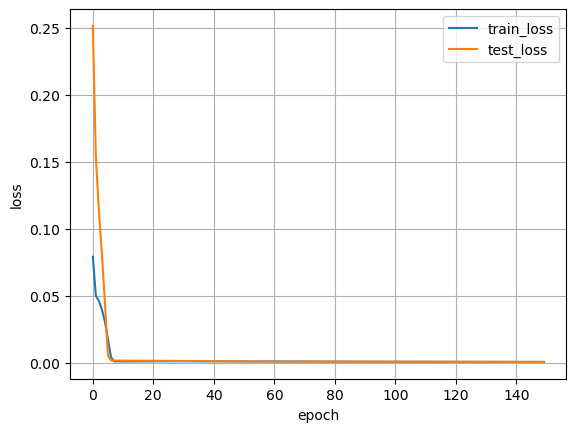

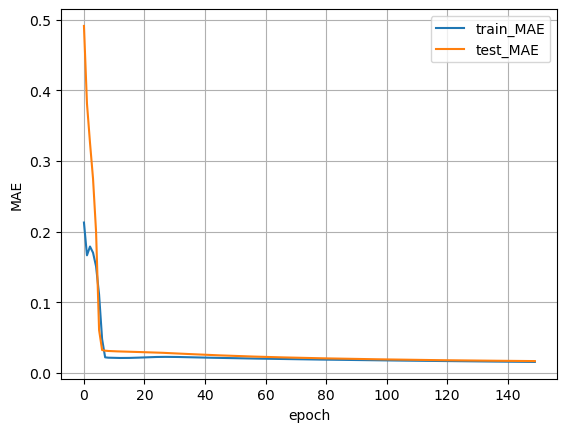

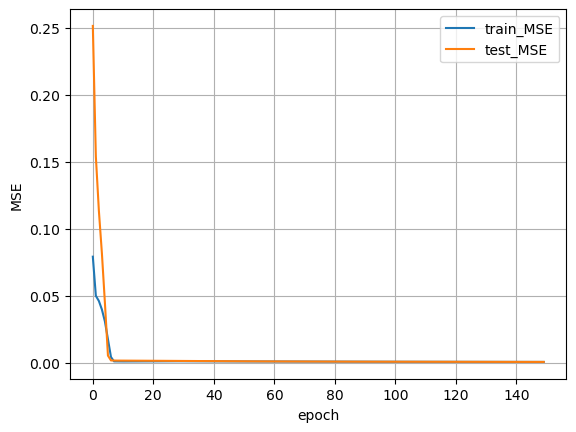

In [14]:
plot_results(train_loss, test_loss)
plot_results(train_mae, test_mae, label_txt='MAE')
plot_results(train_mse, test_mse, label_txt='MSE')

Als nächstes wird ein mehrschichtiges RNN erstellt. Dafür wird die Klasse `RNN` von PyTorch verwendet. Diese verwendet ein `Elman`-RNN.

In [17]:
class PyTorchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PyTorchRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden_state):
        out, hidden_state = self.rnn(input, hidden_state)
        out = self.fc(out)
        return out
    
    def initHidden(self, batch_size, seq_length):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)


In [18]:
# Modell initialisieren
input_size_ptr = data.shape[1]
hidden_size_ptr = 30 #Anzahl der Features auf den versteckten Schichten
num_layers_ptr = 20 # Anzahl der versteckten Schichten
output_size_ptr = data.shape[1]
modelPTR = PyTorchRNN(input_size_ptr, hidden_size_ptr, num_layers_ptr, output_size_ptr)

optimizer_ptr = torch.optim.AdamW(modelPTR.parameters(), lr=0.0001)
loss_fn_ptr = nn.MSELoss()

epochs_ptr = 150

train_loss_ptr, test_loss_ptr, train_mae_ptr, test_mae_ptr, train_mse_ptr, test_mse_ptr = run_model(modelPTR, epochs_ptr, optimizer_ptr, loss_fn_ptr, train_dataloader, test_dataloader, sequence_length)

  0%|          | 0/150 [00:00<?, ?it/s]

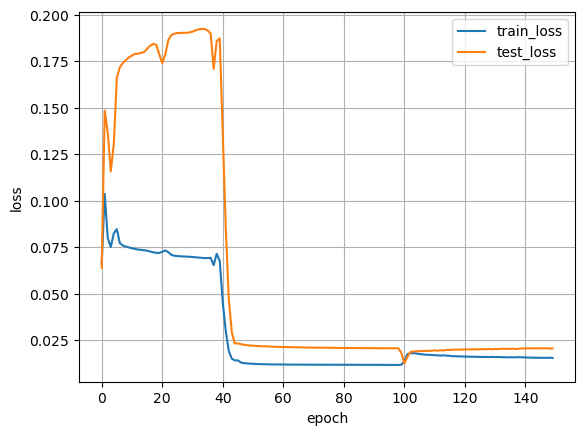

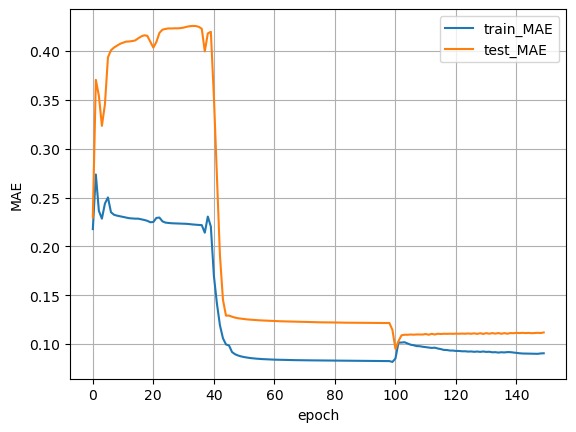

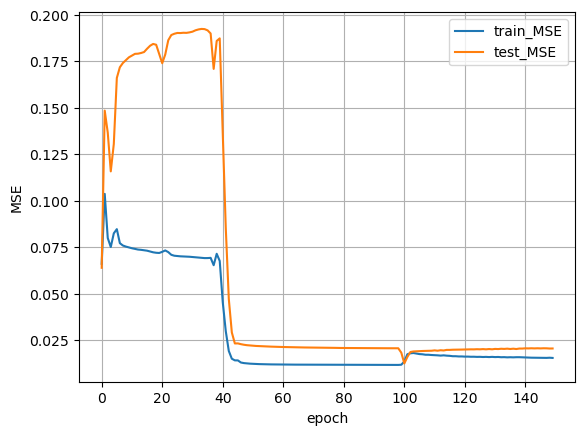

In [19]:
plot_results(train_loss_ptr, test_loss_ptr)
plot_results(train_mae_ptr, test_mae_ptr, label_txt='MAE')
plot_results(train_mse_ptr, test_mse_ptr, label_txt='MSE')

Nun wollen wir prüfen wie gut die Vorhersagen unserers Modells sind. Basierend auf den Grafen der beiden erstellten Modelle verwenden wir das SimpleRNN-Modell, da es die besseren Ergebnisse verspricht.

In [27]:
def predict(model, test_dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.to(device)
            hidden = model.initHidden(inputs.size(0), inputs.size(1)).to(device)
            outputs = model(inputs, hidden)
            output = outputs[:, -1, :]
            predictions.extend(output.cpu().numpy())

    return predictions

In [30]:
def plot_predictions(predictions, train_data, test_data, train_dates, test_dates):
    plt.figure(figsize=(14, 5))
    plt.plot(train_dates[-341:], scaler.inverse_transform(train_data[-341:]), label="Trainingsdaten", color='red')
    plt.plot(test_dates[-341:], scaler.inverse_transform(test_data[-341:]), label="Testdaten", color='blue')
    plt.plot(test_dates[-341:], predictions, label="Vorhersagen", color='green')
    plt.legend()
    plt.xlabel('Datum')
    plt.ylabel('Preis pro Unze in USD')
    plt.title('Trainings-, Test- und Vorhergesagte Preise')
    plt.xticks(rotation=45)
    plt.show()

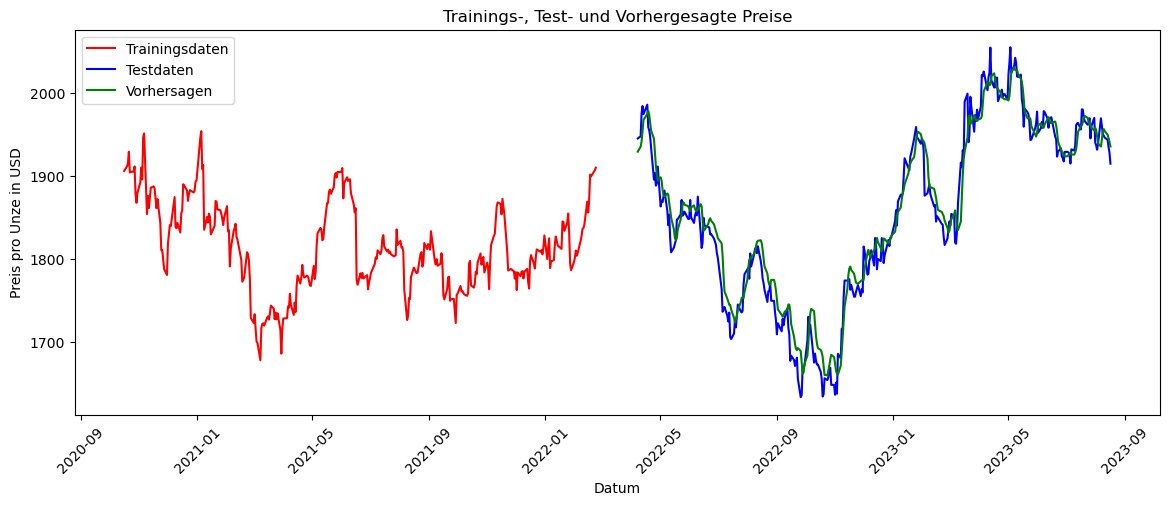

In [32]:
# Vorhersagen treffen
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
predictions = predict(simpleModel, test_dataloader, device)

train_dates = df['Date'][:len(train_data)]
test_dates = df['Date'][len(train_data):len(train_data) + len(test_data)]

# Daten skalieren
predictions = scaler.inverse_transform(predictions)

# Plotten der Ergebnisse
plot_predictions(predictions, train_data, test_data, train_dates, test_dates)

## 6. Aktuelle Modelle
Beispielmodelle Goldpreis-Vorhersagen

### LSTM RNN - Long-Short-Term RNN
Beispiel nach: https://www.kaggle.com/code/ryanburnsworth/lstm-rnn-to-predict-gold-prices

Das erste Beispiel zeigt eine Vorhersage der Goldpreise mittels Long-Short-Term RNN von Ryan Burnsworth [C4].<br>
Das LSTM-Modell ist in Kapitel 3 genauer beschrieben.

#### Import der Python-Bibliotheken
Für dieses Beispiel werden insbesondere die Bibliotheken Numpy, Pandas, Matplotlib und zur Anwendung des RNN Tensorflow benötigt.

In [28]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

#### Grundeinstellungen und fehlende Werte ergänzen
Es werden einige Grundeinstellungen gesetzt. Die Datengrundlage wird den vorgehalten Goldpreis-Daten angepasst, die im Rahmen dieser Arbeit in einem separaten Verzeichnis vorliegen

In [30]:
EPOCHS = 150
BATCH_SIZE = 32
TIMESTEP = 60
#DATA_PATH = "/kaggle/input/gold-stock-prices/goldstock.csv"
DATA_PATH = "Data/gold_prices.csv" #Alternative dataset -CP

Die nachfolgende Funktion ist notwendig, um die Lücken der Goldpreise zwischen Wochenenden und Feiertagen zu schließen. Dafür wird der Schlusswert am Vortag eingesetzt. Dies erzeugt zudem zusätzliche potenzielle Trainingswerte.

In [32]:
"""
  This function takes a dataframe and populates the missing dates in the
  dataframe with the open price set to the close price of the previous day.

  @param df: dataframe
  @return: fully populated dataframe
"""
def populate_missing_date_values(df):
  start_date = df['Date'][0].date()

  # store the dates as a Series
  dates = df['Date']

  dataset = []
  num_days_in_future = 1

  for index, day in enumerate(dates):
    # extract the date from the current row in the dataframe
    current_df_date = str(day.date())

    # skip the first date
    if (index == 0):
      # add the first date to the dataset
      open_price = df['Open'][index]
      day_step = [current_df_date, open_price]
      dataset.append(day_step)
      continue

    # get the open and close prices
    open_price = df['Open'][index]
    close_price = df['Close'][index - 1]

    # get the date of the next day
    current_date = str(start_date + datetime.timedelta(days = num_days_in_future))

    # check if the current date is the same as the current date in the dataframe
    if (current_date != current_df_date):
      found_next_date = False

      # loop until the next date is found
      while not found_next_date:
        if (current_date == current_df_date):
          found_next_date = True

          # add the open price to the dataset
          day_step = [current_date, open_price]
          dataset.append(day_step)
        else:
          # add the close price to the dataset
          day_step = [current_date, close_price]
          dataset.append(day_step)

          # increment the date
          num_days_in_future += 1
          current_date = str(start_date + datetime.timedelta(days=num_days_in_future))
    else:
      # add the open price to the dataset
      day_step = [current_date, open_price]
      dataset.append(day_step)

    num_days_in_future += 1

  return dataset

#### Datentabelle vorbereiten
Der nachfolgende Code bereitet die *Datentabelle* (Dataframe) vor. Zunächst wird die **gold_prices.csv** eingelesen. Damit der Beispielcode nicht zu starkt veändert werden muss, wird die Spalte mit der Überschrift *Close/Last* zu *Close* angepasst.<br>
Die Datumsangabe wird in ein Pandas *Datumsobjekt* umgewandelt. Anschließend werden die Daten nach Datum aufsteigend (ascending) sortiert. <br>
Duplikate werden entfernt und der *Index* neu sortiert, um Lücken zu vermeiden. <br>
Danach wird die vorbereitete Funktion **populate_missing_date_values** ausgeführt, die weiter oben beschrieben ist.<br>
Zuletzt wird die Datentabelle auf die zwei Spalten des Datums und Eröffnungspreises reduziert und die ersten 10 Einträge zur visualisierung angezeigt.

In [38]:
# load the gold stock csv into a dataframe
df = pd.read_csv(DATA_PATH)
df = df.rename(columns={"Close/Last": "Close"}) #Unser Dataframe hat eine Spalte Close/Last --> Diese muss zu "Close" umbenannt werden, damit die nachfolgenden Codes funktionieren
df['Date'] = pd.to_datetime(df['Date'])

# sort by Date - Earliest to latest
df = df.sort_values(by='Date', ascending=True)

# remove duplicate observations
df.drop_duplicates(subset=['Date'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

# populate missing dates and open price values
df = populate_missing_date_values(df)

# create a dataframe with only Date and Open columns
df = pd.DataFrame(df, columns=['Date', 'Open'])
df.head(10)

,Date,Open
0,2013-08-19,1377.1
1,2013-08-20,1364.9
2,2013-08-21,1371.0
3,2013-08-22,1365.6
4,2013-08-23,1376.1
5,2013-08-24,1395.8
6,2013-08-25,1395.8
7,2013-08-26,1394.8
8,2013-08-27,1419.0
9,2013-08-28,1423.0


#### Goldpreise visualisieren
Die Goldpreise werden zum besseren Verständnis visualisert. Zur Verbesserung der Darstellung wird die Größe des Plots zusätzlich manuell angepasst.

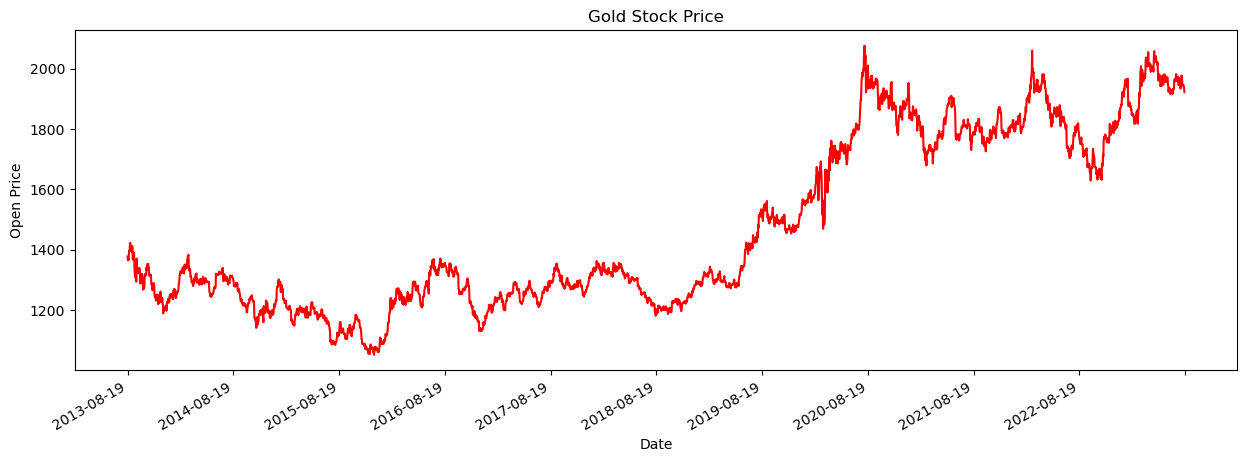

In [34]:
#Goldprices of the last 10 years
plt.figure(figsize=(15, 5)) #Added to set figsize -CP

plt.plot(df['Date'], df['Open'], color='red')

locator = mdate.YearLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Gold Stock Price')
plt.show()

#### Trainingsdaten extrahieren
Alle Daten bis auf die letzten 19 Datensätze werden als Trainingsdaten extrahiert.

In [43]:
# extract the training data and verify it ends at the end of 2023
train_df = df.head(len(df) - 19)
train_df.tail()

,Date,Open
3627,2023-07-25,1957.0
3628,2023-07-26,1966.3
3629,2023-07-27,1973.3
3630,2023-07-28,1945.5
3631,2023-07-29,1960.4


#### Testdaten extrahieren
Im Beispiel sollen die Testdaten ab Januar 2024 extrahiert werden. Die vorliegenden Goldpreis-Daten liegen nur bis **Mitte August 2023** vor.

In [42]:
# extact the test data and verify it starts at January 1st 2024
# Daten nur bis Mitte oktober vorhanden -CP
test_df = df.tail(19)
test_df.reset_index(drop=True, inplace=True)
test_df.head(19)

,Date,Open
0,2023-07-30,1960.4
1,2023-07-31,1959.2
2,2023-08-01,1964.9
3,2023-08-02,1948.4
4,2023-08-03,1934.2
5,2023-08-04,1934.9
6,2023-08-05,1939.6
7,2023-08-06,1939.6
8,2023-08-07,1977.6
9,2023-08-08,1971.5


#### Trainingsdaten als Array
Die im Beispiel genannte Funktion **iloc** gilt als veraltet: "Deprecated since version 2.2.0: Returning a tuple from a callable is deprecated." [C5]

In [57]:
# extract the Open values into a numpy array
X_train = train_df.iloc[:, 1:2].values


In [62]:
sc = MinMaxScaler(feature_range=(0, 1))

# fit the scaler only on X_train
sc.fit(X_train)

# scale X_train values to between 0 and 1
X_train_scaled = sc.transform(X_train)


In [63]:
train_data = []
train_labels = []

# create the training data using 60 timesteps
for i in range(TIMESTEP, len(X_train_scaled)):
  train_data.append(X_train_scaled[i-TIMESTEP:i, 0])
  train_labels.append(X_train_scaled[i, 0])

# convert train_data and train_labels back into numpy arrays
train_data, train_labels = np.array(train_data), np.array(train_labels)

# reshape train_data to be 3D so its compatible with the RNNs input requirements
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))

In [64]:
print(f"Training Data Shape: {train_data.shape}")
print(f"Training Labels Shape: {train_labels.shape}")

Training Data Shape: (3572, 60, 1)
Training Labels Shape: (3572,)


#### LSTM RNN Modell erzeugen

In [65]:
regressor = Sequential()

regressor.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1))))
regressor.add(Dropout(0.1))

regressor.add(Bidirectional(LSTM(units=60, return_sequences=True)))
regressor.add(Dropout(0.1))

regressor.add(Bidirectional(LSTM(units=80, return_sequences=True)))
regressor.add(Dropout(0.2))

regressor.add(Bidirectional(LSTM(units=120)))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

2025-01-12 14:53:28.300729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 14:53:28.907009: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-12 14:53:28.907072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78977 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [66]:
regressor.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [67]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min',patience=20)

#### LSTM RNN Modell trainieren
Im nachfolgenden Code wird die fit-Funktion eingesetzt. Hier findet das Training statt. Beim Ausführen dieses Codes wird je nach Hardware sehr viel Zeit benötigt.

In [68]:
history = regressor.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/150


2025-01-12 14:54:00.273246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2025-01-12 14:54:00.892913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-01-12 14:54:00.893408: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55a56887de40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-12 14:54:00.893426: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-01-12 14:54:00.899267: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-12 14:54:01.025851: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

112/112 [==============================] - 14s 29ms/step - loss: 0.0073
Epoch 2/150
112/112 [==============================] - 3s 29ms/step - loss: 0.0019
Epoch 3/150
112/112 [==============================] - 3s 30ms/step - loss: 0.0017
Epoch 4/150
112/112 [==============================] - 3s 30ms/step - loss: 0.0014
Epoch 5/150
112/112 [==============================] - 3s 29ms/step - loss: 0.0015
Epoch 6/150
112/112 [==============================] - 3s 29ms/step - loss: 0.0015
Epoch 7/150
112/112 [==============================] - 3s 29ms/step - loss: 0.0012
Epoch 8/150
112/112 [==============================] - 3s 30ms/step - loss: 0.0011
Epoch 9/150
112/112 [==============================] - 3s 29ms/step - loss: 0.0011
Epoch 10/150
112/112 [==============================] - 3s 29ms/step - loss: 0.0011
Epoch 11/150
112/112 [==============================] - 3s 29ms/step - loss: 0.0011
Epoch 12/150
112/112 [==============================] - 3s 29ms/step - loss: 0.0010
Epoch 13/150

#### Vorhersagen mit Hilfe der Testdaten


In [69]:
last_60_days_2023 = train_df.iloc[:, 1:2].tail(TIMESTEP)
last_60_days_2023 = pd.concat([last_60_days_2023, test_df.iloc[:, 1:2]])
last_60_days_2023 = sc.transform(last_60_days_2023)

X_test = []
for i in range(TIMESTEP, 79):
  X_test.append(last_60_days_2023[i-TIMESTEP:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [70]:
predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)
predicted_value

1/1 [==============================] - 2s 2s/step


array([[1942.2538],
       [1940.9161],
       [1941.4436],
       [1945.4711],
       [1933.9918],
       [1922.4808],
       [1919.2223],
       [1920.8695],
       [1921.5712],
       [1950.1748],
       [1949.9254],
       [1944.7109],
       [1935.0375],
       [1930.0126],
       [1929.6488],
       [1929.4469],
       [1928.8918],
       [1924.3229],
       [1918.9012]], dtype=float32)

#### Grafische Ausgabe Vorhersage und Testdaten
Die Vorhersage gilt ab dem 30.07.2023.

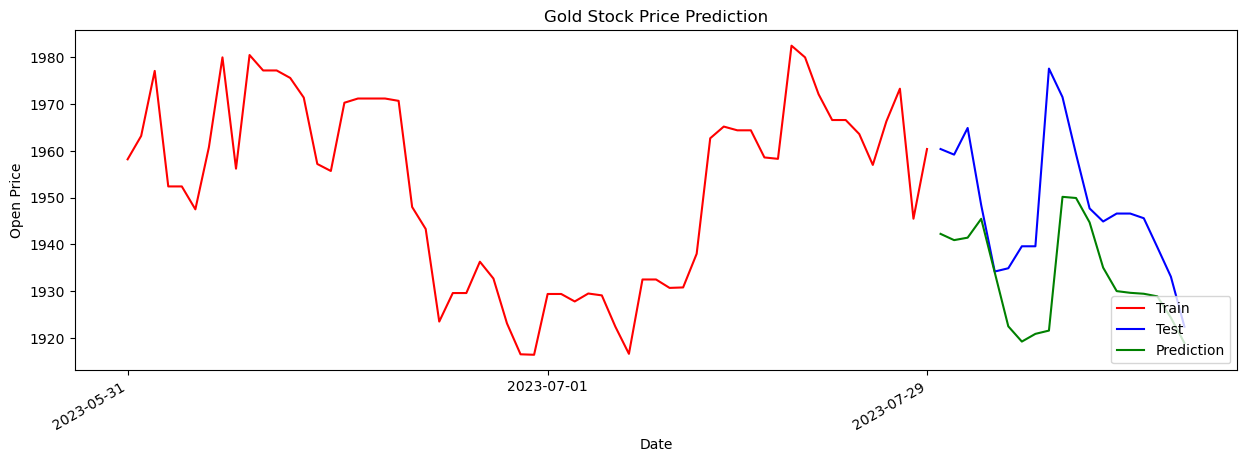

In [78]:
plt.figure(figsize=(15, 5)) #Added to set figsize -CP
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()

plt.plot(train_df.tail(TIMESTEP)['Date'], train_df.tail(TIMESTEP)['Open'], color='red')
plt.plot(test_df['Date'], test_df['Open'], color='blue')
plt.plot(test_df['Date'], predicted_value, color='green')
plt.title('Gold Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(['Train', 'Test', 'Prediction'], loc='lower right')

#### Modell Loss über Epochen
Die größte Verbesserung ist etwa in den ersten 40 Epochen zu erkennen.

Text(0.5, 0, 'Epoch')

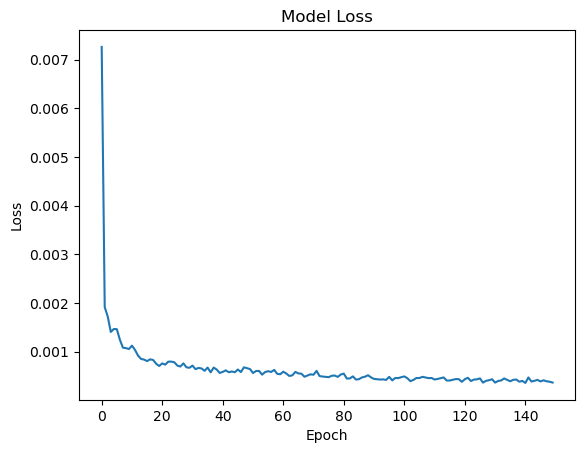

In [73]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

#### Gleiche Vorgehensweise mit 40 Epochen

In [93]:
EPOCHS = 40
history = regressor.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/40
112/112 [==============================] - 3s 28ms/step - loss: 3.0124e-04
Epoch 2/40
112/112 [==============================] - 3s 30ms/step - loss: 3.1132e-04
Epoch 3/40
112/112 [==============================] - 3s 28ms/step - loss: 3.0688e-04
Epoch 4/40
112/112 [==============================] - 3s 30ms/step - loss: 3.1496e-04
Epoch 5/40
112/112 [==============================] - 3s 30ms/step - loss: 3.1212e-04
Epoch 6/40
112/112 [==============================] - 3s 30ms/step - loss: 3.1712e-04
Epoch 7/40
112/112 [==============================] - 3s 30ms/step - loss: 3.0947e-04
Epoch 8/40
112/112 [==============================] - 3s 30ms/step - loss: 3.0671e-04
Epoch 9/40
112/112 [==============================] - 3s 29ms/step - loss: 3.2865e-04
Epoch 10/40
112/112 [==============================] - 3s 29ms/step - loss: 3.2308e-04
Epoch 11/40
112/112 [==============================] - 3s 30ms/step - loss: 3.0323e-04
Epoch 12/40
112/112 [==============================]

In [94]:
predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)
predicted_value

1/1 [==============================] - 0s 40ms/step


array([[1971.4193],
       [1971.8289],
       [1970.4401],
       [1974.4207],
       [1962.0083],
       [1950.8887],
       [1947.6979],
       [1950.5919],
       [1951.0992],
       [1980.652 ],
       [1978.547 ],
       [1971.0464],
       [1962.0333],
       [1958.9208],
       [1959.3682],
       [1957.7317],
       [1958.1364],
       [1952.7587],
       [1946.5009]], dtype=float32)

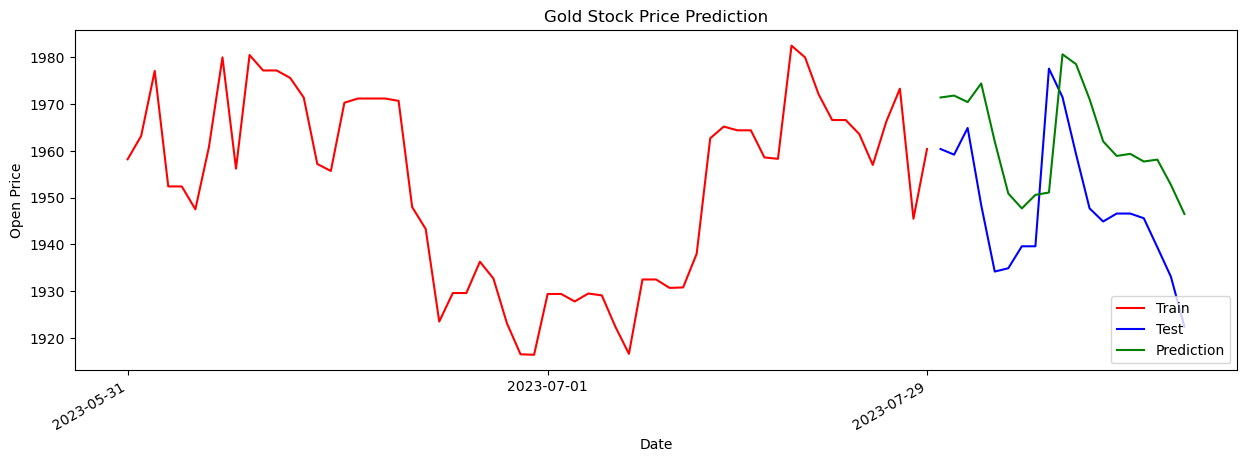

In [95]:
plt.figure(figsize=(15, 5)) #Added to set figsize -CP
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()

plt.plot(train_df.tail(TIMESTEP)['Date'], train_df.tail(TIMESTEP)['Open'], color='red')
plt.plot(test_df['Date'], test_df['Open'], color='blue')
plt.plot(test_df['Date'], predicted_value, color='green')
plt.title('Gold Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(['Train', 'Test', 'Prediction'], loc='lower right')

Text(0.5, 0, 'Epoch')

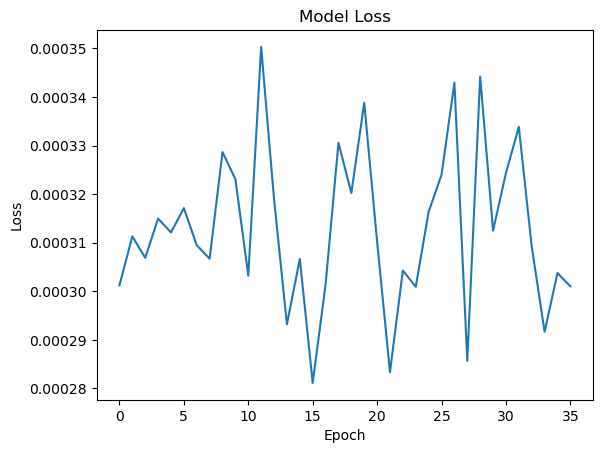

In [96]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Quellen:

* C4: https://www.kaggle.com/code/ryanburnsworth/lstm-rnn-to-predict-gold-prices [Online, Stand: 12.01.2025]
* C5: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html [Online, Stand: 12.01.2025]

### GRU RNN

Beispiel nach: https://www.kaggle.com/code/khashayarrahimi94/gold-price-forecasting-using-lstm-cnn-gru

Als Grundlage wird der Beispielcode mittels Gated Recurrent Unit (GRU) RNN von Khashayar Rahimi verwendet [C6].<br>
Das GRU-Modell ist in Kapitel 3 genauer beschrieben.

Quellen:

* C6: https://www.kaggle.com/code/khashayarrahimi94/gold-price-forecasting-using-lstm-cnn-gru [Online, Stand: 12.01.2025]

## 7. Vergleich der Modelle
Vergleich mit transformer-netwerken?

## 8. Fazit
Eigenes Modell vs. verglichene Standardmodelle.